C:\Users\chris\AppData\Local\Temp\ipykernel_11356\1899474204.py:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dataclean.corr()


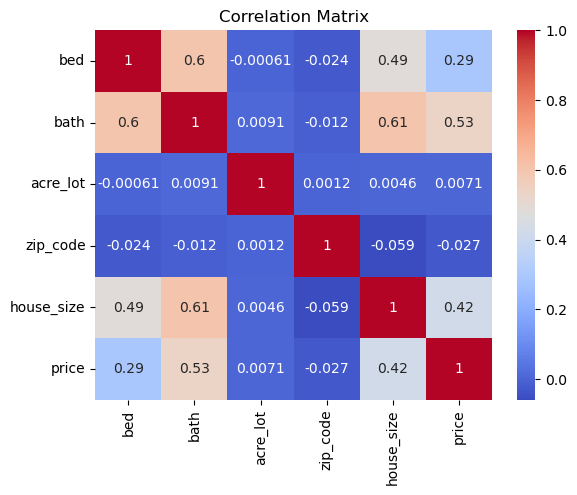

          status  bed  bath  acre_lot    city        state  zip_code  \
829     for_sale  7.0   3.0      0.09  Dorado  Puerto Rico     949.0   
3380    for_sale  7.0   3.0      0.09  Dorado  Puerto Rico     949.0   
5083    for_sale  7.0   3.0      0.09  Dorado  Puerto Rico     949.0   
5387    for_sale  7.0   3.0      0.09  Dorado  Puerto Rico     949.0   
9053    for_sale  7.0   3.0      0.09  Dorado  Puerto Rico     949.0   
...          ...  ...   ...       ...     ...          ...       ...   
904932  for_sale  5.0   6.0      8.60  Armonk     New York   10504.0   
904934  for_sale  4.0   8.0      4.48  Armonk     New York   10504.0   
904935  for_sale  6.0   8.0      3.39  Armonk     New York   10504.0   
904937  for_sale  4.0   7.0      3.94  Armonk     New York   10504.0   
904938  for_sale  6.0   7.0      3.79  Armonk     New York   10504.0   

        house_size prev_sold_date      price  
829         1192.0     2019-06-28   110000.0  
3380        1192.0     2019-06-28   11000

In [3]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
data = pd.read_csv('realestate.csv')
dataclean = data.dropna(axis=0)
data = dataclean
correlation_matrix = dataclean.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
print(dataclean)
# Create a new feature: 'bedroom_per_bathroom' ratio
data['bedroom_per_bathroom'] = data['bed'] / data['bath']
data['bed_bath_interaction'] = data['bed'] * data['bath']
# Assuming 'sale_date' is the column containing sale dates in your DataFrame
data['prev_sold_date'] = pd.to_datetime(data['prev_sold_date'])  # Convert to datetime
reference_date = data['prev_sold_date'].max()  # Find the most recent date
data['days_since_sale'] = (reference_date - data['prev_sold_date']).dt.days
# Create a new feature: 'bedroom_times_bathroom' product
data['bedroom_times_bathroom'] = data['bed'] * data['bath']

# Create a new feature: 'total_rooms' summing bedrooms and bathrooms
data['total_rooms'] = data['bed'] + data['bath']
# Select the relevant columns for the model
X = data[['bed', 'bath', 'house_size', 'bedroom_per_bathroom', 'bedroom_per_bathroom', 'total_rooms', 'bed_bath_interaction', 'days_since_sale']]
y = data['price']
num_folds = 5  # Number of folds for cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Initialize a Linear Regression model and train it
model = LinearRegression()
model.fit(X_train, y_train)
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
# Predictions using Linear Regression

# Predictions using Gradient Boosted Regression
y_gb_pred = gb_model.predict(X_test)
# Add the predicted prices as a new column in the DataFrame
data['predicted_price'] = model.predict(X_poly)
def format_predicted_price(value):
    return '{:.2f}'.format(value)

# Apply the custom formatting function to the 'predicted_price' column
data['predicted_price'] = data['predicted_price'].apply(format_predicted_price)

# Convert 'price' and 'predicted_price' columns to numeric
data['price'] = pd.to_numeric(data['price'], errors='coerce')
data['predicted_price'] = pd.to_numeric(data['predicted_price'], errors='coerce')

# Calculate the absolute percentage error
data['absolute_percentage_error'] = abs((data['price'] - data['predicted_price']) / data['price']) * 100

# Calculate the mean absolute percentage error (MAPE)
mape = data['absolute_percentage_error'].mean()

# Display the MAPE
print('Mean Absolute Percentage Error (MAPE):', mape)
# Evaluate Linear Regression
linear_mae = mean_absolute_error(y_test, y_pred)
linear_mse = mean_squared_error(y_test, y_pred)
linear_r2 = r2_score(y_test, y_pred)

# Evaluate Gradient Boosted Regression
gb_mae = mean_absolute_error(y_test, y_gb_pred)
gb_mse = mean_squared_error(y_test, y_gb_pred)
gb_r2 = r2_score(y_test, y_gb_pred)

print("Linear Regression Metrics:")
print(f"MAE: {linear_mae}")
print(f"MSE: {linear_mse}")
print(f"R^2: {linear_r2}")

print("\nGradient Boosted Regression Metrics:")
print(f"MAE: {gb_mae}")
print(f"MSE: {gb_mse}")
print(f"R^2: {gb_r2}")
# Calculate APE for Linear Regression predictions
# Calculate APE for Linear Regression predictions
data['linear_regression_ape'] = abs((data['price'] - data['predicted_price']) / data['price']) * 100

# Make predictions using Gradient Boosted Regression on the entire dataset
gb_pred = gb_model.predict(X_poly)

# Calculate APE for Gradient Boosted Regression predictions
data['gradient_boosted_ape'] = abs((data['price'] - gb_pred) / data['price']) * 100

from sklearn.ensemble import RandomForestRegressor

# Initialize a Random Forest model and train it
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions using Random Forest
y_rf_pred = rf_model.predict(X_poly)

# Calculate APE for Random Forest predictions
data['random_forest_ape'] = abs((data['price'] - y_rf_pred) / data['price']) * 100

# Compare APEs and find out which model performs better for each data point
better_linear_regression = data[(data['linear_regression_ape'] < data['gradient_boosted_ape']) & (data['linear_regression_ape'] < data['random_forest_ape'])]

better_gradient_boosted = data[(data['gradient_boosted_ape'] < data['linear_regression_ape']) & (data['gradient_boosted_ape'] < data['random_forest_ape'])]

better_random_forest = data[(data['random_forest_ape'] < data['linear_regression_ape']) & (data['random_forest_ape'] < data['gradient_boosted_ape'])]

# Print the results
print("Data points better predicted by Linear Regression:")
print(better_linear_regression)

print("\nData points better predicted by Gradient Boosted Regression:")
print(better_gradient_boosted)

print("\nData points better predicted by Random Forest:")
print(better_random_forest)

# Calculate MAPE for each model on the better-predicted data points
better_linear_regression_mape = better_linear_regression['linear_regression_ape'].mean()
better_gradient_boosted_mape = better_gradient_boosted['gradient_boosted_ape'].mean()
better_random_forest_mape = better_random_forest['random_forest_ape'].mean()

print("MAPE for better Linear Regression:", better_linear_regression_mape)
print("MAPE for better Gradient Boosted Regression:", better_gradient_boosted_mape)
print("MAPE for better Random Forest:", better_random_forest_mape)

# Calculate the weights based on the number of data points
num_linear_regression_better = len(better_linear_regression)
num_gradient_boosted_better = len(better_gradient_boosted)
num_random_forest_better = len(better_random_forest)

total_data_points = num_linear_regression_better + num_gradient_boosted_better + num_random_forest_better
weight_linear_regression = num_linear_regression_better / total_data_points
weight_gradient_boosted = num_gradient_boosted_better / total_data_points
weight_random_forest = num_random_forest_better / total_data_points

# Calculate the combined MAPE
combined_mape = (weight_linear_regression * better_linear_regression_mape) + (weight_gradient_boosted * better_gradient_boosted_mape) + (weight_random_forest * better_random_forest_mape)

print("Combined MAPE:", combined_mape)